# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

1. [Обзор данных](#start)
2. [Предобработка данных](#preprocessing)  
    2.1 [Обработка пропусков](#nan)  
    2.2 [Замена типа данных](#tipdan)  
    2.3 [Обработка дубликатов](#dubli)  
    2.4 [Лемматизация](#lemma)  
    2.5 [Категоризация данных](#katd)
3. [Ответьте на вопросы](#answer)
4. [Общий вывод](#conclusion)

## Обзор данных<a id="start"></a>

Откроем файл с данными и изучим общую информацию.

In [335]:
import pandas as pd
data = pd.read_csv('/datasets/data.csv') # чтение файла с данными и сохранение в data
pd.set_option('display.float_format', '{:.2f}'.format) # установим формат для типа float, для более приятного отображения

from pymystem3 import Mystem # импортируем библиотеку pymystem3
m = Mystem()

from collections import Counter

import seaborn
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

In [336]:
data.info() # получение общей информации о данных в таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [337]:
data.head(10) # получение первых 10 строк таблицы

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.67,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.64,покупка жилья
1,1,-4024.80,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.01,приобретение автомобиля
2,0,-5623.42,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.95,покупка жилья
3,3,-4124.75,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.55,дополнительное образование
4,0,340266.07,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу
5,0,-926.19,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.57,покупка жилья
6,0,-2879.20,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.97,операции с жильем
7,0,-152.78,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.93,образование
8,2,-6929.87,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.83,на проведение свадьбы
9,0,-2188.76,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.94,покупка жилья для семьи


**Вывод**

Итак, в таблице 12 столбцов. В столбцах встречаются различные типы данных: int64, float64, object.

Согласно документации к данным:
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

В каждой строке таблицы — данные о заемщике банка. 

Предварительно можно утверждать, что, данных достаточно для исследования. Но встречаются пропуски, в некотрых столбцах необходимо изменить тип данных, обработать дубликаты и провести категоризацию данных. Помимо того встречаются отрицательные значения в столбце с количеством дней стажа.

Прежде чем приступать к вычислениям и анализу, нужно устранить проблемы в данных.

## Предобработка данных <a id="preprocessing"></a>

### Обработка пропусков <a id="nan"></a>

#### Посмотрим в каких столбцах есть пропуски

Посчитаем, сколько в таблице пропущенных значений.

In [338]:
data.isna().sum() # используем метод isna() для поиска пропусков и метод sum() для подсчета их количества.

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Мы видим что пропуски присутствуют в двух столбцах: `days_employed` и `total_income` (трудовой стаж и ежемесячный доход). Причем количество пропусков совпадает. 

Проверим совпадают ли пропуски в данных столбцах:

In [339]:
data[(data['days_employed'].isna()) & (data['total_income'].isna())].count()  # отфильтруем по двум условиям

children            2174
days_employed          0
dob_years           2174
education           2174
education_id        2174
family_status       2174
family_status_id    2174
gender              2174
income_type         2174
debt                2174
total_income           0
purpose             2174
dtype: int64

Мы видим что каждому пропуску в строке по столбцу со стажем соответствует пропуск в столбце с ежемесячным доходом. Скорее всего причина пропуска техническая ошибка выгрузки данных. Маловероятно что такое количество пользователей не заполняли  именно два этих значения. К тому же пропуски переменной не зависят от значений других переменных (возраст, уровень образования, тип занятости). 

Удаление\игнорирование пропусков в столбце `ежемесячный доход` не представляется возможным. Так как нам предстоит проверить взаимосвязь между уровнем дохода и возвратом кредита в срок. И доля пропусков достаточно большая 10.1% (2174/21525), что может повлиять на вывод. 
Пропуски в столбце `общий трудовой стаж в днях` тоже постараемся заполнить. Возможно будем использовать эти данные для заполнения пропусков в столбце `ежемесячный доход`.
Данные в этих столбцах — количественные переменные. Пропуски в таких переменных заполняют характерными значениями.

#### Заполним пропуски в стобце `общий трудовой стаж в днях`. 
Как мы видели ранее в столбце встречаются отрицательные значения. Скорее всего стаж вычислялся как разница двух дат и возможно были допущены ошибки при их заполнении.  
Избавимся от отрицательных значений. И после переведем дни стажа в годы:

In [340]:
data['days_employed'] = data['days_employed'].abs() # получаем абсолютное значение в столбце
data['days_employed'] = data['days_employed'] / 365 # переводим стаж из дней в годы

data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,23.12,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.64,покупка жилья
1,1,11.03,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.01,приобретение автомобиля
2,0,15.41,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.95,покупка жилья
3,3,11.30,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.55,дополнительное образование
4,0,932.24,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу


После обработки замечаем интересные значения. Так в некоторых строках указан стаж 932 года. Вероятно в этих строках изначально был указан стаж не в днях. Выведем строки в которых стаж больше 75 лет.

In [341]:
data[data['days_employed'] > 75].head() # 75 - максимальный возраст в выборке

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,932.24,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу
18,0,1096.66,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.78,на покупку подержанного автомобиля
24,1,927.54,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.24,операции с коммерческой недвижимостью
25,0,996.02,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.76,покупка недвижимости
30,1,919.40,62,среднее,1,женат / замужем,0,F,пенсионер,0,171456.07,операции с коммерческой недвижимостью


Видим что 900 лет это не предел. Заметим что большинство заемщиков в этой выборке имеют тип занятости "пенсионер". 

In [342]:
data[data['days_employed'] > 75]['income_type'].value_counts()

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

Посмотрим сколько строк с аномально большим стажем:

In [343]:
'Количество строк с аномальным стажем:', data[data['days_employed'] > 75]['days_employed'].count() 

('Количество строк с аномальным стажем:', 3445)

Сравним количество этих строк с количеством пенсионеров: 

In [344]:
'Количество пенсионеров:', data[data['income_type'] == 'пенсионер']['income_type'].count()

('Количество пенсионеров:', 3856)

Выходит почти 90% данных по стажу у пенсионеров указаны с ошибкой.

Количество таких строк достаточно большое, удалить не получиться.  
Предположим что в этих строках указан стаж в часах. Проверим - разделим текущие значения на 24:

In [345]:
data.loc[data['days_employed'] > 75,'days_employed'] /= 24 # переводим стаж из дней в годы

data[data['income_type'] == 'пенсионер'].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,38.84,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу
12,0,nan,65,среднее,1,гражданский брак,1,M,пенсионер,0,nan,сыграть свадьбу
18,0,45.69,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.78,на покупку подержанного автомобиля
24,1,38.65,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.24,операции с коммерческой недвижимостью
25,0,41.50,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.76,покупка недвижимости


Теперь стаж по этим заемщикам выглядит на первый взгляд вполне правдоподобно. Если учитывать высокий возраст пенсионеров и стаж 38-42 лет.

Соотнесем расчитанный таким образом стаж с возрастом всех "пенсионеров" в выборке: 

In [346]:
data_pensioner = data[data['income_type'] == 'пенсионер'] # отфильтруем таблицу 

# сгруппируем по годам "пенсионеров" и выведем статистику по стажу:
data_pensioner.groupby('dob_years')['days_employed'].agg({'days_employed':['mean', 'max', 'min','count']})   

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  after removing the cwd from sys.path.


days_employed                  
                   mean   max   min count
dob_years                                
0                 41.39 45.78 37.85    17
22                38.22 38.22 38.22     1
24                  nan   nan   nan     0
26                43.02 44.45 41.59     2
27                41.33 43.32 37.65     3
28                39.99 39.99 39.99     1
31                  nan   nan   nan     0
32                38.74 40.30 37.54     3
33                41.74 45.42 38.06     2
34                44.07 45.38 42.07     3
35                41.04 41.04 41.04     1
36                41.89 43.06 40.46     3
37                41.14 43.82 38.69     5
38                41.67 45.09 38.26     8
39                43.04 45.58 41.41     4
40                42.16 45.46 38.03     7
41                41.64 45.28 37.53     6
42                41.43 45.73 38.40     9
43                40.96 45.25 38.32     9
44                41.31 44.58 37.55    10
45                41.54 45.40 38.06    10
46                42.53 45.73 37.64    13
47                41.97 45.72 38.13    13
48                43.16 45.61 40.32    20
49                41.45 45.77 37.72    30
50                41.42 45.80 37.57    61
51                41.04 45.61 37.54    73
52                41.57 45.82 37.77    95
53                41.34 45.78 37.61   105
54                41.66 45.84 37.54   145
55                41.79 45.84 37.54   162
56                41.78 45.86 37.53   184
57                41.78 45.84 37.55   212
58                41.56 45.84 37.55   208
59                41.65 45.85 37.56   254
60                41.58 45.85 37.55   243
61                41.50 45.85 37.56   214
62                41.74 45.83 37.53   235
63                41.74 45.85 37.64   192
64                41.70 45.83 37.62   179
65                41.85 45.81 37.63   136
66                41.91 45.82 37.56   139
67                41.42 45.82 37.73   132
68                41.92 45.84 37.60    80
69                41.72 45.86 37.62    74
70                41.61 45.81 37.69    54
71                41.91 45.63 37.60    48
72                42.03 45.66 37.53    28
73                41.73 45.61 38.44     6
74                41.07 43.40 38.99     4

Как видим из сгруппированной таблицы стаж по годам практически не меняется. И если для пенсионеров возрастом выше 60 лет вполне нормально иметь стаж 41 год, то для пенсионеров младше это является недопустимым.  
Помимо того встречаются молодые пенсионеры (от 22 до 40 лет), а также у 17 человек указан возраст 0.  

На основании этого можно сделлать вывод о том, что указанные аномально большие данные стажа в этих строках преобразовать в приемлемый вид не получается и они являются некорректными, по крайней меры для половины значений. Похоже на техническую ошибку так как у большинства заемщиков значения стажа очень похожи.   
Можно заполнить пропуски стажа и заменить аномальные значения стажа медианой. Но точность данных стажа снизится, а пропуски ежемесячного дохода можно заполнить с помощью других переменных.  
Для заполнения пропусков в столбце ежемесячный доход вместо `стажа` будем использовать данные по `возрасту` и еще нескольких переменных.

Заполним пропуски стажа медианой с группировкой по семейному статусу:

In [347]:
for family in data['family_status'].unique():
    median = data.loc[data['family_status'] == family, 'days_employed'].median()
    data.loc[(data['days_employed'].isna()) & (data['family_status'] == family), 'days_employed'] = median

In [348]:
'Количество пропусков после:', data['days_employed'].isna().sum()

('Количество пропусков после:', 0)

После преобразования стажа из дней в годы, логичным будет переименовать столбец `days_employed` в `years_employed`. 


In [349]:
data = data.rename(columns={'days_employed':'years_employed'})

#### Заполним пропуски в столбце `ежемесячный доход`. 
Для заполнения пропусков логичным будет ориентироваться на `тип занятости`, `пол клиента` и `возраст клиента`. От этих переменных зависит уровень ежемесячного дохода.

**Начнем с возраста клиента**:

Как мы видели ранее, в столбце возраст встречаются значения "0", что по сути является неявным пропуском либо ошибкой заполнения.  
Посмотрим сколько таких значений в данных:

In [350]:
"Количество клиентов с возрастом '0':", data[data['dob_years'] == 0]['dob_years'].count()

("Количество клиентов с возрастом '0':", 101)

Всего 101 значение. Можно заменить эти значения медианой по типу занятости ,семейному статусу. и скорее всего это будет не очень корректно. Но их настолько мало что они не сильно повлияют на конечный расчет. Будем игнорировать их при расчете медианы по доходу.

Чтобы нам не расчитывать медину по каждому "году" возраста сформируем категории по возрастным группам:

In [351]:
def age_group(age): # объявлем функцию, которая возвращает возврастную группу по значению возраста
                # разделяем на 6 возрастных групп: "до 25", "от 25 до 35", "от 35 до 45","от 45 до 55""от 55 до 65" "cвыше 65".
    if age <= 25:        
        return 'до_25'
    if age <= 35:
        return 'от_25_до_35'
    if age <= 45:
        return 'от_35_до_45'
    if age <= 55:
        return 'от_45_до_55'
    if age <= 65:
        return 'от_55_до_65'
    return 'выше_65' 

In [352]:
age_group(50) # проверим работу функции

'от_45_до_55'

In [353]:
age_group(23) # проверим работу функции

'до_25'

Добаляем новый столбец "Возрастная группа"

In [354]:
data['age_group'] = data['dob_years'].apply(age_group)  

data.loc[:, ['dob_years', 'age_group']].head(10)       # Проверим как добавился новый столбец

,dob_years,age_group
0,42,от_35_до_45
1,36,от_35_до_45
2,33,от_25_до_35
3,32,от_25_до_35
4,53,от_45_до_55
5,27,от_25_до_35
6,43,от_35_до_45
7,50,от_45_до_55
8,35,от_25_до_35
9,41,от_35_до_45


**Проверим столбец "тип занятости":**

Выводим уникальные значения в столбце занятость и их количество.

In [355]:
data['income_type'].value_counts() 

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Тип занятости "предприниматель" можно объединить с "компаньон". По сути компаньон это совладелец бизнеса как и предприниматель который владеет бизнесом.

In [356]:
data['income_type'] = data['income_type'].replace('предприниматель', 'компаньон') # заменяем значения в столбце тип занятости

In [357]:
data['income_type'].value_counts() # проверяем как прошла замена

сотрудник      11119
компаньон       5087
пенсионер       3856
госслужащий     1459
безработный        2
студент            1
в декрете          1
Name: income_type, dtype: int64

**Посмотрим столбец "пол клиента":**

Выводим уникальные значения в столбце пол клиента и их количество.

In [358]:
data['gender'].value_counts() 

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Значение "XNA" в столбце пол клиента всего одно. Определить пол по другим данным в таблице не получится. Но удалять его не будем. Убирем его при расчетах.

**Теперь все готово для расчета медианы дохода по трем переменным.**

Сформируем сводную таблицу по строкам `тип занятости` и `возрастная группа`. По столбцам  `пол клиента`. В значениях будет медиана ежемесячного дохода.

In [359]:
data_p = data[(data['dob_years'] != 0) & (data['gender'] != 'XNA')]

data_pivot = data_p.pivot_table(index=['income_type', 'age_group', 'gender'], values='total_income',
                              aggfunc='median')
data_pivot_ri = data_pivot.reset_index() # убирем мультииндекс чтобы ссылаться на таблицу по столбцам

data_pivot_ri.head(10)

,income_type,age_group,gender,total_income
0,безработный,от_25_до_35,M,59956.99
1,безработный,от_35_до_45,F,202722.51
2,в декрете,от_35_до_45,F,53829.13
3,госслужащий,выше_65,F,163060.54
4,госслужащий,выше_65,M,173045.86
5,госслужащий,до_25,F,135659.90
6,госслужащий,до_25,M,152474.69
7,госслужащий,от_25_до_35,F,131796.54
8,госслужащий,от_25_до_35,M,202125.19
9,госслужащий,от_35_до_45,F,135671.04


Создадим функцию fill_income(), которая вернет медиану из сводной таблицы в зависимости от 3 параметров:  
`тип занятости`, `возрастная группа` и `пол клиента`.

In [360]:
def fill_income(income_type, age_group, gender):
    for i in range(len(data_pivot_ri)):
        if (data_pivot_ri.loc[i,'income_type'] == income_type) & (data_pivot_ri.loc[i,'age_group'] == age_group) & (data_pivot_ri.loc[i,'gender'] == gender):
            return data_pivot_ri.loc[i,'total_income']

In [361]:
a = 'сотрудник'  # Проверим как работает функция
b = 'от_25_до_35'
c = 'F'
fill_income(a, b, c)

129991.30336401633

С помощью цикла и функции заполним пустые значения в столбце `ежемесячный доход`.

In [362]:
fata = data[data['total_income'].isna()].index # сохраняем в список индексы пропущенных строк
                                        # Перебираем индексы пропусков и передаем в функцию значения столбцов.
                                        # Затем функция возвращает соответствующее значение из сводной.              
for i in fata:      
    data.loc[i,'total_income'] = fill_income(data.loc[i, 'income_type'], data.loc[i, 'age_group'], data.loc[i, 'gender'])

In [363]:
'Количество пропусков после:', data['total_income'].isna().sum()

('Количество пропусков после:', 0)

**Посмотрим на столбец `количество детей`:**  
Данные по детям нам в дальнейшем пригодятся для анализа.

In [364]:
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Мы видим отрицательные значения что является ошибкой. Возможно технилогической. Также обращает внимание большое количество детей "20" у 76 клиентов. Вероятно человеческий фактор. Но так как наш вопрос о влиянии наличия детей, а не количества на возврат кредита, то оставим это без изменений.  
Избавимся от отрицательных значений. 

In [365]:
data['children'] = data['children'].abs()

In [366]:
data['children'].value_counts()

0     14149
1      4865
2      2055
3       330
20       76
4        41
5         9
Name: children, dtype: int64

Отрицательных значений нет, все в порядке.

**Вывод**

Мы обнаружили пропуски в двух столбцах. В столбце `общий трудовой стаж в днях` исправили отрицательные значения, обнаружили аномально высокие значенния стажа и в итоге отказались от использования данных этого столбца, т.к. ошибок было очень много.  
В столбце `ежемесячный доход` заменили пустые значения медианой рассчитаной по трем переменным: `тип занятости`, `пол клиента` и `возраст клиента`.  
Избавились от отрицательных значений в столбце `количество детей`.

### Замена типа данных <a id="tipdan"></a>

Заменим в столбце `ежемесячный доход` тип данных вещественный `float` на целочисленный `int`:

In [367]:
data['total_income'] = data['total_income'].astype('int')

Заменим в столбце `трудовой стаж` тип данных вещественный `float` на целочисленный `int`:

In [368]:
data['years_employed'] = data['years_employed'].astype('int')

Преобразуем числа в столбце `debt` в тип `bool`:

In [369]:
data['debt'] = data['debt'].astype('bool')

Проверим наши преобразования:

In [370]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children            21525 non-null int64
years_employed      21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null bool
total_income        21525 non-null int64
purpose             21525 non-null object
age_group           21525 non-null object
dtypes: bool(1), int64(6), object(6)
memory usage: 2.0+ MB


**Вывод**

Для замены типа данных был использован универсальный метод astype(). Метод astype() позволяет нам четко указать тип, который мы хотим получить. А также он подходит для числовых типов данных.

### Обработка дубликатов <a id="dubli"></a>

Чтобы учесть все явные дубликаты, необходимо проверить есть ли в строковых столбцах различия по регистру. Если такие строки окажутся, все символы в строке привидем к нижнему регистру вызовом метода lower():

Проверим значения в столбцах типа object: `education` , `family_status`, `purpose`. Остальные столбцы типа object мы смотрели. В них регистр единый.

В данном столбце `education` явно необходимо привести регистр в порядок:

In [371]:
data['education'].value_counts() 

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Приводим к единому регистру значения в столбце "уровень образования":

In [372]:
data['education'] = data['education'].str.lower() 

Теперь уровень образование в едином регистре:

In [373]:
data['education'].value_counts() 

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

В столбце семейный статус с регистром все в порядке, неявных дубликатов нет.

In [374]:
data['family_status'].value_counts() 

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

В столбце цель кредита с регистром все в порядке. Но данные явно стоит приводить к категориям. Займемся этим позже в следующем пункте.

In [375]:
data['purpose'].value_counts() 

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Выведем количество явных дубликатов:

In [376]:
f'Количество дубликатов: {data.duplicated().sum()}'

71

Удалим явные дубликаты из таблицы.

In [377]:
data = data.drop_duplicates().reset_index(drop=True) # с удалением старых индексов и формированием новых

In [378]:
'Количество дубликатов после удаления:', data.duplicated().sum()

('Количество дубликатов после удаления:', 0)

**Вывод**

Для поиска явных дубликатов использовался метод duplicated(). Привели к единому регистру значения в столбце `уровень образования`.  
Чтобы найти неявные дубликаты просматривали уникальные значения в столбце. Причиной появления явных дубликатов может быть ошибка выгрузки данных.  
Для поиска уникальных значений использовалися метод value_counts(). 

### Лемматизация <a id="lemma"></a>

Лемматизируем  значения из столбца `цель получения кредита`:

In [379]:
lemmas_purpose = []                             # пройдемся по всем строкам столбца
for i in range(len(data)):                      # сохраним в списке результаты лематизации значений
    lemmas = m.lemmatize(data.loc[i,'purpose'])
    lemmas_purpose.append(lemmas)

В результате получился список списков. Преобразуем все в один список:

In [380]:
lemmas_purpose_long = []
for row in lemmas_purpose:
    for word in row:
        lemmas_purpose_long.append(word)
             

Подсчитаем число упоминаний лемматизированных слов в столбце `цель получения кредита`:

In [381]:
Counter(lemmas_purpose_long)

Counter({'покупка': 5897,
         ' ': 33570,
         'жилье': 4460,
         '\n': 21454,
         'приобретение': 461,
         'автомобиль': 4306,
         'дополнительный': 906,
         'образование': 4013,
         'сыграть': 765,
         'свадьба': 2324,
         'операция': 2604,
         'с': 2918,
         'на': 2222,
         'проведение': 768,
         'для': 1289,
         'семья': 638,
         'недвижимость': 6351,
         'коммерческий': 1311,
         'жилой': 1230,
         'строительство': 1878,
         'собственный': 635,
         'подержать': 478,
         'свой': 2230,
         'со': 627,
         'заниматься': 904,
         'сделка': 941,
         'подержанный': 486,
         'получение': 1314,
         'высокий': 1374,
         'профильный': 436,
         'сдача': 651,
         'ремонт': 607})

**Вывод**

Провели лемматизацию с помощью билиотеки `pymystem3`. После подсчитали число упоминаний слов, что позволяет выявить популярные слова в столбце `цель получения кредита`.

### Категоризация данных <a id="katd"></a>

В таблице есть два столбца `уровень образования клиента` и `семейное положение`. Для каждого из них имеется столбец с идентификатором. Выделим словарь для каждого параметра.

Создадим таблицу где каждому типу `образования` соответствеут идентификатор. А потом удалим из нее дубликаты.

In [382]:
education_dict = data[['education','education_id']]
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
education_dict

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


Создадим словаль и для параметра `семейное положение`:

In [383]:
family_status_dict = data[['family_status','family_status_id']]
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
family_status_dict

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


**Для дальнейшего исследования нам понадобиться сравнивать уровень дохода и возврат кредита в срок. Поэтому сгруппируем данные дохода.** 

Посмотрим на статистические данные столбца `ежемесячный доход`, посмотрим как распределены уровни дохода:

In [384]:
data['total_income'].describe()

count     21454.00
mean     165369.29
std       98299.74
min       20667.00
25%      107103.75
50%      144229.50
75%      198024.75
max     2265604.00
Name: total_income, dtype: float64

С помощью функции сгруппирем данные:

In [385]:
def income_group(income): # объявлем функцию, которая возвращает группу по значению ежемесячного дохода
                          # разделяем на 6 групп дохода: от 0 до 250 000 с шагом 50 000 и свыше 250 000.
    if income <= 50000:        
        return 'до 50 тыс'
    if income <= 100000:
        return 'от_ 50_до_100 тыс'
    if income <= 150000:
        return 'от_100_до_150 тыс'
    if income <= 200000:
        return 'от_150_до_200 тыс'
    if income <= 250000:
        return 'от_200_до_250 тыс'
    return 'свыше_250 тыс' 

Проверим как работает функция:

In [386]:
income_group(112080) 

'от_100_до_150 тыс'

In [387]:
income_group(45000) 

'до 50 тыс'

In [388]:
data['income_group'] = data['total_income'].apply(income_group) # Добаляем новый столбец "Уровень дохода"

data.loc[:, ['total_income', 'income_group']].head(10)       # Проверим как добавился новый столбец

,total_income,income_group
0,253875,свыше_250 тыс
1,112080,от_100_до_150 тыс
2,145885,от_100_до_150 тыс
3,267628,свыше_250 тыс
4,158616,от_150_до_200 тыс
5,255763,свыше_250 тыс
6,240525,от_200_до_250 тыс
7,135823,от_100_до_150 тыс
8,95856,от_ 50_до_100 тыс
9,144425,от_100_до_150 тыс


**Также нам понадобиться сравнивать цель кредита и возврат кредита в срок. Поэтому классифицируем цели кредита.**

Чтобы класифицировать цели кредита по группам применим лемматизацию к данным столбца `purpose`.

Создадим функцию которая будет принимать текст и лемматизировать его, потом сравнивать результат лемматизации с условиями и возвращать Группу для целей кредита:

In [389]:
def lemmatize_group(text):
    lemma = m.lemmatize(text)       # На основе лемматизации из пункта 2.4 выделим 6 групп.
    if 'образование' in lemma:      # Как правило в банках цели Ремонт, Свадьба могут объединять в одну группу "на личные нужды"
        return 'Образование'        # но мы в этом проекте выделим их в отдельные группы.
    if 'ремонт' in lemma:
        return 'Ремонт'
    if 'автомобиль' in lemma:
        return 'Автомобиль'
    if 'строительство' in lemma:
        return 'Строительство'
    if 'недвижимость' in lemma:
        return 'Недвижимость'
    if 'свадьба' in lemma:
        return 'Свадьба'
    if 'жилье' in lemma:
        return 'Недвижимость'
    return 'группа не определена, необходимо добавить условие' # добавим вывод такой строки на случай 
                                                               # если ни одно из условий не отработает

Добавим новый столбец к основным данным с группами целей кредита:

In [390]:
data['purpose_group'] = data['purpose'].apply(lemmatize_group)

In [391]:
data.loc[:, ['purpose', 'purpose_group']].head(10)

,purpose,purpose_group
0,покупка жилья,Недвижимость
1,приобретение автомобиля,Автомобиль
2,покупка жилья,Недвижимость
3,дополнительное образование,Образование
4,сыграть свадьбу,Свадьба
5,покупка жилья,Недвижимость
6,операции с жильем,Недвижимость
7,образование,Образование
8,на проведение свадьбы,Свадьба
9,покупка жилья для семьи,Недвижимость


Проверим все ли условия в функции отработали, не осталось ли строк с неопределенной группой.

In [392]:
data['purpose_group'].value_counts() # все отлично, все группы определены

Недвижимость     8326
Автомобиль       4306
Образование      4013
Свадьба          2324
Строительство    1878
Ремонт            607
Name: purpose_group, dtype: int64

Разделим заемщиков на две группы: "Есть дети" (есть хотя бы один ребенок), "Нет детей".

In [393]:
def having_children(children): # объявлем функцию, которая определяет наличие детей
                               # разделяем на 2 группы:  "Есть дети"  и "Нет детей".
    if children != 0:        
        return 'Есть дети'
    return 'Нет детей'

In [394]:
data['having_childr'] = data['children'].apply(having_children)
data.loc[:, ['children', 'having_childr']].head(10)

,children,having_childr
0,1,Есть дети
1,1,Есть дети
2,0,Нет детей
3,3,Есть дети
4,0,Нет детей
5,0,Нет детей
6,0,Нет детей
7,0,Нет детей
8,2,Есть дети
9,0,Нет детей


**Вывод**

Мы выделили два словаря по параметрам `уровень образования клиента` и `семейное положение`. Провели категоризацию по уровню дохада клиентов и целям кредита для дальнейшего анализа.

## Ответьте на вопросы <a id="answer"></a>

**- Есть ли зависимость между наличием детей и возвратом кредита в срок?**

In [395]:
pd.set_option('display.float_format', '{:.1%}'.format) # для красивого отображения процентов

Выведем сводную таблицу по двум группам и посчитаем количество имевшихся задолженностей по возврату кредитов, а также количество всех кредитов.

In [396]:
data_pivot_children = data.pivot_table(index=['having_childr'], values='debt',
                              aggfunc=['sum', 'count'], margins=True)
data_pivot_children['ratio'] = data_pivot_children['sum'] / data_pivot_children['count'] # добавим долю возврата кредита

data_pivot_children['sum'] = data_pivot_children['sum'].astype(int) # меняю тип т.к. при суммировании 'bool' получается 'float'

data_pivot_children

,sum,count,ratio
,debt,debt,
having_childr,,,
Есть дети,678,7363,9.2%
Нет детей,1063,14091,7.5%
All,1741,21454,8.1%


Значение в столбце `ratio` показывает долю кредитов, по которым имелась задолженность. Мы делим количество задолженностей по возврату на общее количество кредитов.

**Вывод**

Как мы видим из сводной таблицы: наличие детей влияет на возврат кредита. Но это влияние не сильно выраженное. Доля просрочек у заемщиков с детьми выше на 1.7% чем у заемщиков без детей и на 1.1% выше доли просрочек по всем заемщикам.

**- Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Аналогичные операции производим с параметром `семейное положение`:

In [397]:
data_pivot_family = data.pivot_table(index=['family_status'], values='debt',
                              aggfunc=['sum', 'count'])
data_pivot_family['ratio'] = data_pivot_family['sum'] / data_pivot_family['count']
data_pivot_family['sum'] = data_pivot_family['sum'].astype(int) # меняю тип т.к. при суммировании 'bool' получается 'float'

data_pivot_family.sort_values(by = 'ratio', ascending = False)

,sum,count,ratio
,debt,debt,
family_status,,,
Не женат / не замужем,274,2810,9.8%
гражданский брак,388,4151,9.3%
женат / замужем,931,12339,7.5%
в разводе,85,1195,7.1%
вдовец / вдова,63,959,6.6%


**Вывод**

Как мы видим семейный статус не значительно оказывает влиянние на просрочку по кредиту. Чуть хуже возвращают кредиты Не женатые\ Не замужние и те кто живут в Гражданском браке. А меньше всего проблем с кредитом у вдов и вдовцов.

**- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

In [398]:
data_pivot_income = data.pivot_table(index=['income_group'], values='debt',
                              aggfunc=['sum', 'count'])
data_pivot_income['ratio'] = data_pivot_income['sum'] / data_pivot_income['count']
data_pivot_income['sum'] = data_pivot_income['sum'].astype(int) # меняю тип т.к. при суммировании 'bool' получается 'float'
data_pivot_income.sort_values(by = 'ratio', ascending = False)

,sum,count,ratio
,debt,debt,
income_group,,,
от_150_до_200 тыс,440,4913,9.0%
от_100_до_150 тыс,582,6906,8.4%
от_ 50_до_100 тыс,331,4096,8.1%
от_200_до_250 тыс,171,2355,7.3%
свыше_250 тыс,194,2812,6.9%
до 50 тыс,23,372,6.2%


В данном случае можно построить диаграмму по уровню дохода и посмотреть как меяется доля просрочек от уровня дохода:

('Гистограмма распределения доли просрочек по уровню дохода',
 <matplotlib.axes._subplots.AxesSubplot at 0x7f503d87b690>)

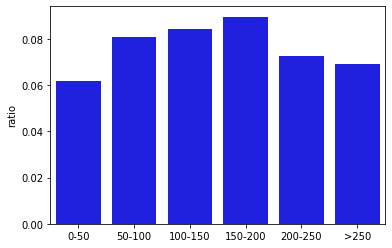

In [399]:
import seaborn
income_level = ['0-50', '50-100', '100-150', '150-200', '200-250', '>250'] 
'Гистограмма распределения доли просрочек по уровню дохода', seaborn.barplot(x=income_level, y=data_pivot_income['ratio']
                                                                             , color='blue')

**Вывод**

Как мы видим на графике при росте уровня дохода от 50 тысяч до 200 тысяч доля просрочек растет, а после 200 тысяч снижается. Больше всего задолженностей по кредиту среди заемщиков с уровнем дохода от 150 до 200 тысяч.  
Но меньше всего просрочек у людей с ежемесячным доходом до 50 тысяч и у людей с доходом свыше 250 тысяч. 

**- Как разные цели кредита влияют на его возврат в срок?**

Аналогично сформируем сводную таблицу по `целям кредита`.

In [400]:
data_pivot_purpose = data.pivot_table(index=['purpose_group'], values='debt',
                              aggfunc=['sum', 'count'])
data_pivot_purpose['ratio'] = data_pivot_purpose['sum'] / data_pivot_purpose['count']
data_pivot_purpose['sum'] = data_pivot_purpose['sum'].astype(int) # меняю тип т.к. при суммировании 'bool' получается 'float'
data_pivot_purpose.sort_values(by = 'ratio', ascending = False) 

,sum,count,ratio
,debt,debt,
purpose_group,,,
Автомобиль,403,4306,9.4%
Образование,370,4013,9.2%
Свадьба,186,2324,8.0%
Строительство,144,1878,7.7%
Недвижимость,603,8326,7.2%
Ремонт,35,607,5.8%


**Вывод**

Мы видим что доля просрочек в зависимости от целей кредита меняется. Но варьируется в пределах 4%. Больше всего просрочек у тех кто берет кредит на Автомобиль и Образование. Меньше всего проблем с кредитом у тех кто занимает на ремонт.

## Общий вывод<a id="conclusion"></a>

Много вопросов возникает к качеству предоставленных данных. Достаточной много пропусков и технологических ошибок. Что не может не влиять на качество исследования. Заказчику стоит уделить больше внимание качеству данных.  
Часть ошибок мы постарались устранить и провести исследование.

**Мы провели исследование надёжности заёмщиков.**  

Выявили зависимость между возвратом кредита в срок и:
- наличием детей;
- семейным положением;
- уровнем дохода.
Наличие детей немного усложняет возврат кредита. Семейным заемщикам чуть легче возвращать кредит чем тем кто без супруга. А достаточно средний уровень дохода не гарантирует возврат кредита в срок.

Увидели как разные цели кредита влияют на его возврат в срок. Автолюбителям сложней возвращать кредит.  